In [4]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np

**Data Taken From:** https://www.kaggle.com/wordsforthewise/lending-club </br>
**Model is From:** https://www.kaggle.com/benesalvatore/predict-default-using-logisitic-regression

In [5]:
features = ['loan_amnt', 'annual_inc', 'term', 'emp_length']

In [10]:
# Reading a CSV file into a pandas DataFrame with selected columns
a = pd.read_csv('../accepted_2007_to_2018Q4.csv', usecols=features+['loan_status'])

In [11]:
# Encoding the loan_status column to numeric values
full_set = a.query("loan_status in ('Fully Paid', 'Charged Off')").copy()

In [12]:
full_set = full_set.dropna(subset=['emp_length'])

# Build the model - Logistic Regression

1. Transform our Label *loan_status* and other columns

In [13]:
full_set['loan_status'] = full_set['loan_status'].replace(
    {
        'Fully Paid': 1,
        'Charged Off': 0
    }
)

full_set['term'] = full_set['term'].replace(
    {
        ' 36 months': 36,
        ' 60 months': 60
    }
)

In [14]:
full_set['emp_length'] = full_set['emp_length'].map(lambda x: x.split(' ')[0])
full_set['emp_length'] = full_set['emp_length'].map(lambda x: str(x).replace('+', '').replace('<', '0'))

**Build Model**

In [15]:
model_features = list(full_set.columns)
model_features.remove('loan_status')

In [16]:
full_set.head()

,loan_amnt,term,emp_length,annual_inc,loan_status
0,3600.0,36,10,55000.0,1
1,24700.0,36,10,65000.0,1
2,20000.0,60,10,63000.0,1
4,10400.0,60,3,104433.0,1
5,11950.0,36,4,34000.0,1


In [17]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    full_set[model_features],
    full_set['loan_status'],
    random_state=42
)

In [18]:
# Creating an instance of a Logistic Regression model
model = LogisticRegression()
scaler = MinMaxScaler()

In [19]:
# Creating a pipeline with scaling and logistic regression steps
pipeline = Pipeline([('scaler', scaler), ('model', model)])

In [20]:
# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

**Test Model**

ROC-AUC-score:  0.634209472479741


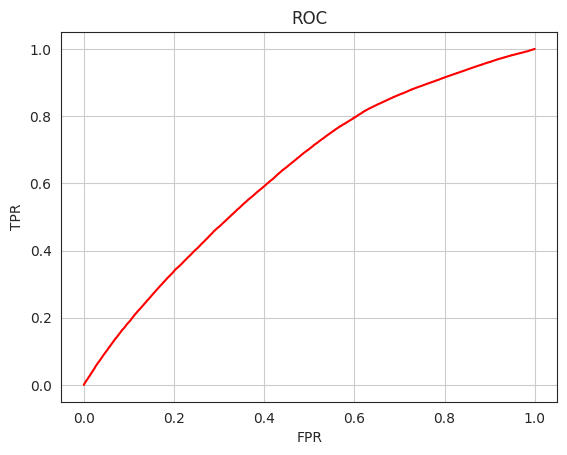

In [21]:
# Predicting the probabilities for the test set
test_probas = pipeline.predict_proba(X_test)[:,1]

fpr, tpr, tresholds = roc_curve(y_test, test_probas)
# Plotting the ROC curve
plt.plot(fpr, tpr, color='red')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

print('ROC-AUC-score: ', roc_auc_score(y_test, test_probas))

In [22]:
def _compute_accuracy_for_thresholds(data: pd.core.frame.DataFrame):
    """
    Compute Classifier's Accuracy for various thresholds
    """
    
    thresholds = np.linspace(0, 1, 100)
    
    accuracies = []
    
    for threshold in thresholds:
        preds = data['preds'].map(lambda x: 1 if x > threshold else 0)
        accuracy_ = accuracy_score(data['labels'].values, preds)
        accuracies.append(accuracy_)
    
    return accuracies, thresholds

In [23]:
X_test['preds'] = test_probas
X_test['labels'] = y_test

In [24]:
accuracies, thresholds = _compute_accuracy_for_thresholds(X_test)

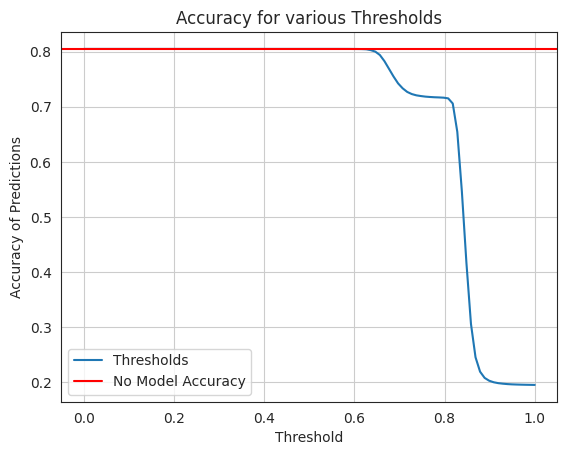

In [25]:
plt.plot(thresholds.reshape(-1, 1), accuracies, label='Thresholds')
plt.axhline(
    (X_test['labels'].sum()) / len(X_test), color='red', label='No Model Accuracy')
plt.grid()
plt.title('Accuracy for various Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy of Predictions')
plt.legend()
plt.show()

In [26]:
accuracy_score(X_test['labels'].values, list(map(lambda x: 1 if x > 0.7 else 0, X_test['preds'])))

0.7393148089674771

**Save Pipeline**

In [27]:
# Saving the trained pipeline to a file
with open('app/model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [28]:
model = pickle.load(
    open('app/model.pkl', 'rb')
)